# 1. Setup

In [ ]:
import sys
from pathlib import Path

# import gc

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import datetime
import copy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
PROJECT_ROOT = Path().resolve().parent
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"
PARQUET_DATA_PATH = "../data/parquet_data/"
sys.path.append(str(Path().resolve().parent))

In [ ]:
from utils.loading import load_parquet_data
from utils.feature_engineering import get_month_splits
from utils.data_pipeline import DataPipeline

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
    "display.max_rows",
    100,
    "display.max_columns",
    100,
)
sns.set_style("whitegrid")

In [ ]:
def plot_time_splits(splits: list[dict[str, pd.Timestamp]]):
    """
    Plot time-based train/test splits.

    Parameters
    ----------
    splits : list of dict
        Each element must contain:
        {
            "train": (start_timestamp, end_timestamp),
            "test": (start_timestamp, end_timestamp)
        }
    """

    fig, ax = plt.subplots(figsize=(10, max(3, len(splits) * 0.8)))

    for i, split in enumerate(splits):
        train_start, train_end = split["train"]
        test_start, test_end = split["test"]
        train_duration = train_end - train_start
        test_duration = test_end - test_start

        ax.barh(
            y=i,
            width=train_duration,
            left=train_start,
            height=0.3,
            label="train" if i == 0 else "",
            color="tab:blue",
        )

        ax.barh(
            y=i,
            width=test_duration,
            left=test_start,
            height=0.3,
            label="test" if i == 0 else "",
            color="tab:orange",
        )

    ax.set_yticks(range(len(splits)))
    ax.set_yticklabels([f"split_{i}" for i in range(len(splits))])

    ax.set_xlabel("time")
    ax.set_ylabel("split")

    ax.legend()
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    plt.title("Splits Boundaries")
    plt.tight_layout()
    plt.show()

In [ ]:
CATEGORICAL_F = ["county", "product_type", "is_business", "is_consumption"]
RECORD_F = CATEGORICAL_F + ["datetime"]
RAND = 10

# 2. Data Preparation

In [ ]:
dp = DataPipeline(PARQUET_DATA_PATH)
dp.load()
dp.prepare()

In [ ]:
dp.merge()

In [ ]:
LAG_SPECS = {
    "2d": {
        "3h": ["mean", "count"],
        "6h": ["mean", "count"],
        "24h": ["mean", "median", "std", "count"],
    },
    "3d": {
        "6h": ["mean", "count"],
        "12h": ["mean", "median", "count"],
    },
    "7d": {
        "12h": ["mean", "count"],
        "24h": ["mean", "median", "std", "count"],
    },
}

In [ ]:
dp.add_features(LAG_SPECS, CATEGORICAL_F, "datetime", "target")

In [ ]:
df = dp.df

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 81 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   county                                category      
 1   product_type                          category      
 2   is_business                           category      
 3   is_consumption                        category      
 4   datetime                              datetime64[ns]
 5   target                                float32       
 6   eic_count                             float32       
 7   installed_capacity                    float32       
 8   lowest_price_per_mwh                  float32       
 9   highest_price_per_mwh                 float32       
 10  euros_per_mwh                         float32       
 11  f1_temperature                        float32       
 12  f1_dewpoint                           float32       
 13  f1_snowfall_mm         

# 3. Baseline Comparison

## Train-Test Splits

In [ ]:
start_ts = df["datetime"].min()
end_ts = df["datetime"].max()

print(
    f"First timestamp: {start_ts}",
    f"Last timestamp: {end_ts}",
    f"Time range: {end_ts - start_ts}",
    sep="\n",
)

First timestamp: 2021-09-01 00:00:00
Last timestamp: 2023-05-31 23:00:00
Time range: 637 days 23:00:00


Because the total datetime range in the data is 21 months long, and the total number of observations is more than `2,000,000`, this dataset can be split into train and test as follows for simplicity: training data is before 2023, testing data is from 2023, and April and May 2023 are the final test months. January, February, and March are validation months / test-strategy months. Because of the data nature (arriving each day) and potential concept drift, this is a suitable choice (and on the other hand it is not an extreme variant such as retraining every day with new data).

The total datetime range spans 21 months with more than `2,000,000` observations. For simplicity and methodological clarity, the data is split as follows:
- Training period: from September 2021 to December 2022.
- Validation period (strategy selection): January to March 2023.
- Final holdout test period: April and May 2023.

Since the data arrives sequentially and potential concept drift is expected, models are retrained monthly before predicting each subsequent month. This setup reflects a realistic production-like scenario without introducing extreme schemes such as daily retraining.

In [ ]:
# splits = get_month_splits(start_ts, 17, 2, 1, 3)
splits = get_month_splits(start_ts, 16, 1, 1, 5)
splits_val = splits[:3]
splits_test = splits[3:]
print("Validation", *splits_val, sep='\n')
print("Test", *splits_test, sep='\n')

Validation
{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2022-12-31 23:00:00')), 'test': (Timestamp('2023-01-01 00:00:00'), Timestamp('2023-01-31 23:00:00'))}
{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2023-01-31 23:00:00')), 'test': (Timestamp('2023-02-01 00:00:00'), Timestamp('2023-02-28 23:00:00'))}
{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2023-02-28 23:00:00')), 'test': (Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-31 23:00:00'))}
Test
{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2023-03-31 23:00:00')), 'test': (Timestamp('2023-04-01 00:00:00'), Timestamp('2023-04-30 23:00:00'))}
{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2023-04-30 23:00:00')), 'test': (Timestamp('2023-05-01 00:00:00'), Timestamp('2023-05-31 23:00:00'))}


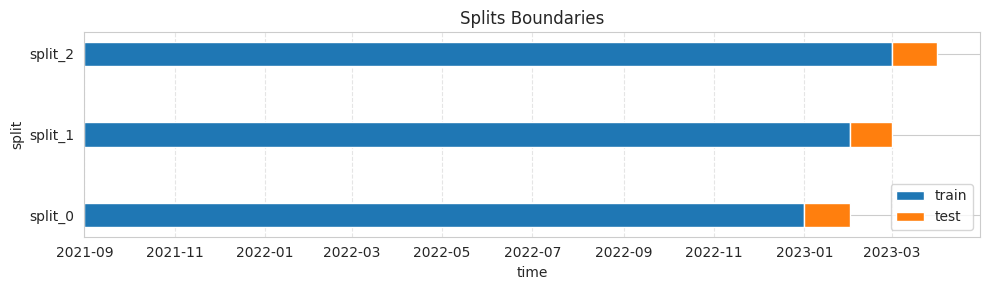

In [ ]:
plot_time_splits(splits_val)

## Direct Comparison

### Models Training

In [ ]:
FEATURES_TO_DROP = ["datetime", "target"]

In [ ]:
cat_cols = df.select_dtypes(include=["bool", "category"]).columns.to_list()
cat_cols

['county',
 'product_type',
 'is_business',
 'is_consumption',
 'national_holiday',
 'observance_day',
 'season_event',
 'dst']

In [ ]:
scores = []
results = {
    "XGB": np.zeros(len(df), dtype=np.float32),
    "LGBM": np.zeros(len(df), dtype=np.float32),
    "CB": np.zeros(len(df), dtype=np.float32),
}
(
    xgb_mae_history,
    lgbm_mae_history,
    cb_mae_history,
    naive_mae,
) = (
    [],
    [],
    [],
    [],
)

xgb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "enable_categorical": True,
    "eval_metric": "mae",
    "n_jobs": -1,
}
lgbm_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression_l1",
    "metric": "mae",
    "n_jobs": -1,
    "force_col_wise": True,
    "verbosity": -1,
}
cb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "loss_function": "MAE",
    "cat_features": cat_cols,
    "eval_metric": "MAE",
    "thread_count": -1,
    "allow_writing_files": False,
    "verbose": False,
}

for i, split in enumerate(splits_val):

    train_mask = (df["datetime"] >= split["train"][0]) & (
        df["datetime"] <= split["train"][1]
    )
    X_train, y_train = (
        df.loc[
            train_mask,
            df.columns.difference(FEATURES_TO_DROP, sort=False),
        ],
        df.loc[train_mask, "target"],
    )

    test_mask = (df["datetime"] >= split["test"][0]) & (
        df["datetime"] <= split["test"][1]
    )
    X_test, y_test = (
        df.loc[
            test_mask,
            df.columns.difference(FEATURES_TO_DROP, sort=False),
        ],
        df.loc[test_mask, "target"],
    )

    # Eval set for tracking progress over iterations
    eval_idx = X_train.sample(100_000, random_state=RAND).index
    eval_set = [(X_train.loc[eval_idx], y_train.loc[eval_idx])]

    for model_name, model_cls, model_params in [
        ("XGB", XGBRegressor, xgb_p),
        ("LGBM", LGBMRegressor, lgbm_p),
        ("CB", CatBoostRegressor, cb_p),
    ]:
        model = model_cls(**model_params)

        if isinstance(model, XGBRegressor):
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                verbose=0,
            )
            xgb_mae_history.append(model.evals_result())

        elif isinstance(model, LGBMRegressor):
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
                eval_set=eval_set,
            )
            lgbm_mae_history.append(model.evals_result_)

        else:
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                cat_features=cat_cols,
            )
            cb_mae_history.append(model.evals_result_)

        preds = model.predict(X_test)
        results[model_name][X_test.index] = preds
        scores.append(
            {
                "Split": i,
                "Model": model_name,
                "MAE": MAE(y_test, preds),
            }
        )

    # Naive baseline
    scores.append(
        {
            "Split": i,
            "Model": "Naive",
            "MAE": MAE(
                y_test.loc[X_test["target_lag_2d"].notna()],
                X_test["target_lag_2d"].dropna(),
            ),
        }
    )

In [ ]:
# scores = []
# (
#     xgb_mae_history,
#     lgbm_mae_history,
#     cb_mae_history,
#     naive_mae,
# ) = (
#     [],
#     [],
#     [],
#     [],
# )

# xgb_p = {
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 7,
#     "random_state": RAND,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "objective": "reg:absoluteerror",
#     "enable_categorical": True,
#     "eval_metric": "mae",
#     "n_jobs": -1,
# }
# lgbm_p = {
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 7,
#     "random_state": RAND,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "objective": "regression_l1",
#     "metric": "mae",
#     "n_jobs": -1,
#     "force_col_wise": True,
#     "verbosity": -1,
# }
# cb_p = {
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 7,
#     "random_state": RAND,
#     "subsample": 0.8,
#     "colsample_bylevel": 0.8,
#     "loss_function": "MAE",
#     "cat_features": cat_cols,
#     "eval_metric": "MAE",
#     "thread_count": -1,
#     "allow_writing_files": False,
#     "verbose": False,
# }

# for i, split in enumerate(splits_val):

#     train_mask = (df["datetime"] >= split["train"][0]) & (
#         df["datetime"] <= split["train"][1]
#     )
#     X_train, y_train = (
#         df.loc[
#             train_mask,
#             df.columns.difference(FEATURES_TO_DROP, sort=False),
#         ],
#         df.loc[train_mask, "target"],
#     )

#     test_mask = (df["datetime"] >= split["test"][0]) & (
#         df["datetime"] <= split["test"][1]
#     )
#     X_test, y_test = (
#         df.loc[
#             test_mask,
#             df.columns.difference(FEATURES_TO_DROP, sort=False),
#         ],
#         df.loc[test_mask, "target"],
#     )

#     eval_idx = X_train.sample(100_000, random_state=RAND).index
#     eval_set = [(X_train.loc[eval_idx], y_train.loc[eval_idx])]

#     for model_name, model_cls, model_params in [
#         ("XGB", XGBRegressor, xgb_p),
#         ("LGBM", LGBMRegressor, lgbm_p),
#         ("CB", CatBoostRegressor, cb_p),
#     ]:
#         model = model_cls(**model_params)

#         if isinstance(model, XGBRegressor):
#             model.fit(
#                 X_train,
#                 y_train,
#                 eval_set=eval_set,
#                 verbose=0,
#             )
#             xgb_mae_history.append(model.evals_result())

#         elif isinstance(model, LGBMRegressor):
#             model.fit(
#                 X_train,
#                 y_train,
#                 categorical_feature=cat_cols,
#                 eval_set=eval_set,
#             )
#             lgbm_mae_history.append(model.evals_result_)

#         else:
#             model.fit(
#                 X_train,
#                 y_train,
#                 eval_set=eval_set,
#                 cat_features=cat_cols,
#             )
#             cb_mae_history.append(model.evals_result_)

#         scores.append(
#             {
#                 "Split": i,
#                 "Model": model_name,
#                 "MAE": MAE(y_test, model.predict(X_test)),
#             }
#         )
#         # del model
#         # gc.collect()

#     # Naive baseline
#     scores.append(
#         {
#             "Split": i,
#             "Model": "Naive",
#             "MAE": MAE(
#                 y_test.loc[X_test["target_lag_2d"].notna()],
#                 X_test["target_lag_2d"].dropna(),
#             ),
#         }
#     )

### Results

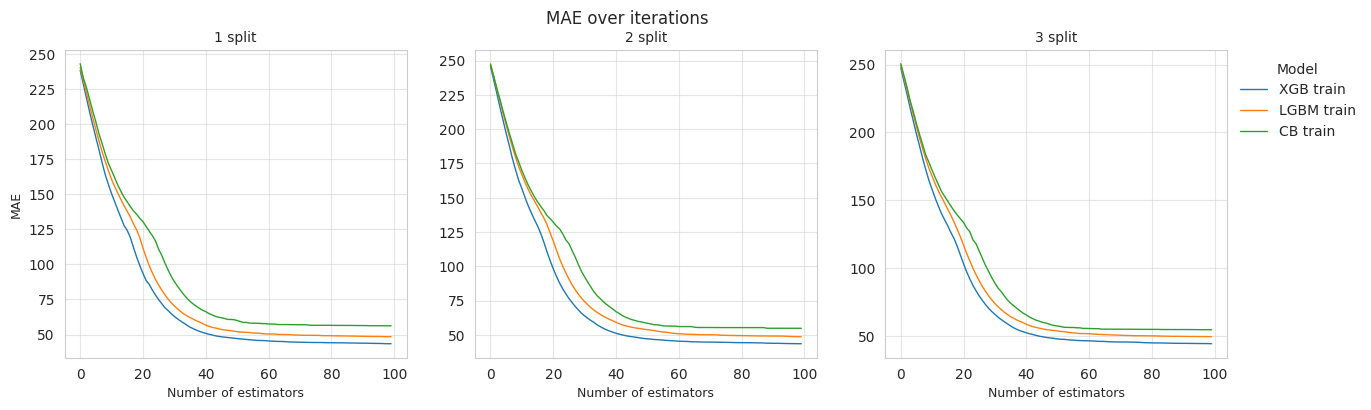

In [ ]:
total_splits = len(splits_val)
rows, cols = 1, total_splits
fig, axs = plt.subplots(rows, cols, figsize=(15, 4))
axs = axs.flatten()

for split_i in range(total_splits):
    ax = axs[split_i]
    ax.plot(
        xgb_mae_history[split_i]["validation_0"]["mae"],
        "C0",
        label=f"XGB train",
        lw=1,
    )
    ax.plot(
        # lgbm_mae_history[split_i]["training"]["l1"],
        lgbm_mae_history[split_i]["valid_0"]["l1"],
        "C1",
        label=f"LGBM train",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["learn"]["MAE"],
        "C2",
        label=f"CB train",
        lw=1,
    )

    if split_i >= total_splits - cols:
        ax.set_xlabel("Number of estimators", size=9)
    if split_i in [i * cols for i in range(rows)]:
        ax.set_ylabel("MAE", size=9)
    ax.set_title(f"{split_i + 1} split", size=10)
    ax.grid(which="both", alpha=0.5)

plt.legend(
    title="Model",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
fig.suptitle(
    "MAE over iterations",
    # y=1.0125,
    fontsize=12,
)
plt.show()

In [ ]:
scores_df = pd.DataFrame(scores)
scores_df

,Split,Model,MAE
0,0,XGB,49.91
1,0,LGBM,54.92
2,0,CB,66.36
3,0,Naive,71.22
4,1,XGB,43.81
5,1,LGBM,46.33
6,1,CB,55.73
7,1,Naive,75.59
8,2,XGB,68.74
9,2,LGBM,72.29


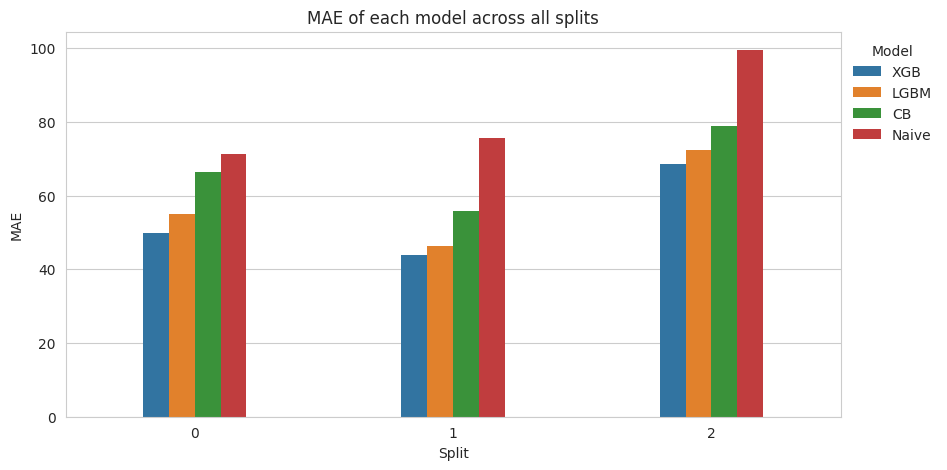

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=scores_df,
    x="Split",
    y="MAE",
    hue="Model",
    width=0.4,
    linewidth=0,
)

plt.title("MAE of each model across all splits")
plt.legend(
    title="Model",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.show()

In [ ]:
scores_df.groupby(
    "Model",
    as_index=False,
    sort=False,
    observed=True,
)["MAE"].mean()
# 	Model	MAE
# 0	XGB	74.26
# 1	LGBM	77.50
# 2	CB	83.70
# 3	Naive	108.52

,Model,MAE
0,XGB,54.15
1,LGBM,57.85
2,CB,66.99
3,Naive,82.12


The XGBoost baseline shows the best results while the LightGBM baseline performs slightly worse. The gap with the CatBoost baseline is more significant, and XGBoost clearly outperforms the naive baseline.

In [ ]:
val_period_start = splits_val[0]["test"][0]
val_period_end = splits_val[2]["test"][1]

In [ ]:
comparison_df = df.copy()
models = ["xgb", "lgbm", "cb"]
baselines_results = [model + "_baseline" for model in models]
baseline_errors = [result + "_error" for result in baselines_results]

comparison_df[baselines_results] = pd.DataFrame(results)

comparison_df = comparison_df.loc[
    (df["datetime"] >= val_period_start) & (df["datetime"] <= val_period_end)
]

comparison_df[baseline_errors] = (
    comparison_df[baselines_results].sub(comparison_df["target"], axis=0).abs()
)

In [ ]:
comparison_df.groupby(
    ["is_consumption", "is_business", "product_type"],
    as_index=True,
    sort=True,
    observed=True,
)[baseline_errors].agg(["mean"])

xgb_baseline_error  \
                                                      mean   
is_consumption is_business product_type                      
0              0           1                         11.93   
                           2                          0.95   
                           3                         46.92   
               1           0                          5.23   
                           1                          6.22   
                           2                          1.34   
                           3                         28.83   
1              0           1                         22.13   
                           2                          3.44   
                           3                         71.83   
               1           0                         97.09   
                           1                         51.46   
                           2                         39.65   
                           3                        203.45   

                                        lgbm_baseline_error cb_baseline_error  
                                                       mean              mean  
is_consumption is_business product_type                                        
0              0           1                          12.21             12.59  
                           2                           0.95              0.97  
                           3                          49.29             49.67  
               1           0                           5.18              5.27  
                           1                           6.34              6.55  
                           2                           1.28              1.20  
                           3                          30.16             30.40  
1              0           1                          23.72             26.90  
                           2                           3.66              3.92  
                           3                          78.04             83.32  
               1           0                          96.98            110.91  
                           1                          53.33             55.65  
                           2                          37.74             40.28  
                           3                         222.77            283.01

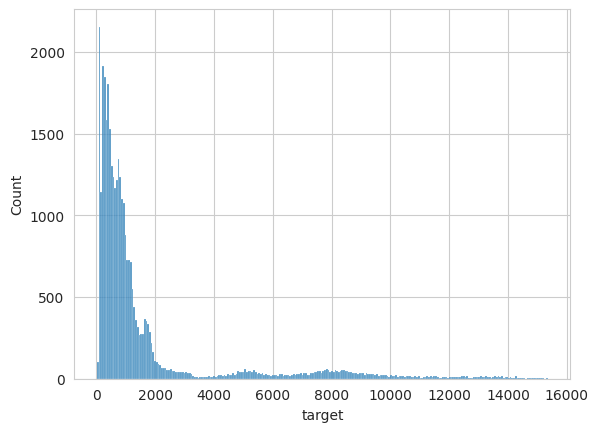

In [ ]:
sns.histplot(
    comparison_df.loc[
        (comparison_df["is_consumption"] == 1)
        & (comparison_df["is_business"] == 1)
        & (comparison_df["product_type"] == 3)
    ]["target"]
)
plt.show()

## Separate Models for Consumption and Production

### Models Training

In the first notebook, it was verified that for each combination of `datetime`, `county`, `product_type`, and `is_business`, there is exactly one consumption and one production value (i.e., no class imbalance in this regard). It was also shown that while there are some similarities between the two target types, there are also notable differences. Therefore, it may be beneficial to train separate models for each target type.

In [ ]:
separate_pc_scores = []

for i, split in enumerate(splits_val):
    for is_cons in df["is_consumption"].unique():

        train_mask = (
            (df["datetime"] >= split["train"][0])
            & (df["datetime"] <= split["train"][1])
            & (df["is_consumption"] == is_cons)
        )
        X_train, y_train = (
            df.loc[
                train_mask,
                df.columns.difference(FEATURES_TO_DROP, sort=False),
            ],
            df.loc[train_mask, "target"],
        )

        test_mask = (
            (df["datetime"] >= split["test"][0])
            & (df["datetime"] <= split["test"][1])
            & (df["is_consumption"] == is_cons)
        )
        X_test, y_test = (
            df.loc[
                test_mask,
                df.columns.difference(FEATURES_TO_DROP, sort=False),
            ],
            df.loc[test_mask, "target"],
        )

        for model_name, model_cls, model_params in [
            ("XGB", XGBRegressor, xgb_p),
            ("LGBM", LGBMRegressor, lgbm_p),
            ("CB", CatBoostRegressor, cb_p),
        ]:
            model = model_cls(**model_params)

            if isinstance(model, XGBRegressor):
                model.fit(
                    X_train,
                    y_train,
                    verbose=0,
                )
            elif isinstance(model, LGBMRegressor):
                model.fit(
                    X_train,
                    y_train,
                    categorical_feature=cat_cols,
                )
            else:
                model.fit(
                    X_train,
                    y_train,
                    cat_features=cat_cols,
                )

            separate_pc_scores.append(
                {
                    "Split": i,
                    "Consumption": is_cons,
                    "Model": model_name,
                    "MAE": MAE(y_test, model.predict(X_test)),
                }
            )
            # del model
            # gc.collect()

        # Naive baseline
        separate_pc_scores.append(
            {
                "Split": i,
                "Consumption": is_cons,
                "Model": "Naive",
                "MAE": MAE(
                    y_test.loc[X_test["target_lag_2d"].notna()],
                    X_test["target_lag_2d"].dropna(),
                ),
            }
        )

### Results

In [ ]:
separate_pc_scores_df = pd.DataFrame(separate_pc_scores)
separate_pc_scores_df

In [ ]:
sns.catplot(
    data=separate_pc_scores_df,
    x="Consumption",
    y="MAE",
    hue="Model",
    col="Split",
    kind="bar",
    height=5,
    width=0.7,
    linewidth=0,
    aspect=0.6,
).fig.suptitle("MAE across splits by prosumer activity", y=1.025)

plt.show()

In [ ]:
# 	Model	MAE
# 0	XGB	66.11
# 1	LGBM	69.18
# 2	CB	80.62
# 3	Naive	108.52


In [ ]:
separate_pc_scores_df.groupby(["Model"], as_index=False, sort=False, observed=True)["MAE"].mean()

On average, the two-model approach achieves a lower monthly MAE compared to the single-model alternative.

## Fixed vs Expanding Splits

In [ ]:
# splits_val

In [ ]:
# plot_time_splits(get_month_splits(start_ts, 17, 2, 1, 3))

In [ ]:
# plot_time_splits(get_month_splits(start_ts, 17, 1, 1, 4))

In [ ]:
# get_month_splits(start_ts, 17, 1, 1, 4)

In [ ]:
# [{'train': (Timestamp('2021-09-01 00:00:00'),
#    Timestamp('2023-01-31 23:00:00')),
#   'test': (Timestamp('2023-02-01 00:00:00'),
#    Timestamp('2023-02-28 23:00:00'))},
#  {'train': (Timestamp('2021-10-01 00:00:00'),
#    Timestamp('2023-02-28 23:00:00')),
#   'test': (Timestamp('2023-03-01 00:00:00'),
#    Timestamp('2023-03-31 23:00:00'))},
#  {'train': (Timestamp('2021-11-01 00:00:00'),
#    Timestamp('2023-03-31 23:00:00')),
#   'test': (Timestamp('2023-04-01 00:00:00'),
#    Timestamp('2023-04-30 23:00:00'))},
#  {'train': (Timestamp('2021-12-01 00:00:00'),
#    Timestamp('2023-04-30 23:00:00')),
#   'test': (Timestamp('2023-05-01 00:00:00'),
#    Timestamp('2023-05-31 23:00:00'))}]